In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Part A — Preprocessing + EDA

**A1) Load data + quick summary + missing values + class counts**

In [4]:
train_path = "/content/drive/MyDrive/train.csv"
test_path  = "/content/drive/MyDrive/test.csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)
print("\nTrain columns:", list(train_df.columns))

print("\nMissing values in TRAIN:")
print(train_df.isna().sum())

print("\nMissing values in TEST:")
print(test_df.isna().sum())

print("\nClass distribution (TRAIN):")
print(train_df["price_class"].value_counts().sort_index())
print("\nClass distribution % (TRAIN):")
print((train_df["price_class"].value_counts(normalize=True).sort_index() * 100).round(2))

Train shape: (41348, 7)
Test shape : (7297, 7)

Train columns: ['neighbourhood_group', 'room_type', 'minimum_nights', 'amenity_score', 'number_of_reviews', 'availability_365', 'price_class']

Missing values in TRAIN:
neighbourhood_group     839
room_type               611
minimum_nights         1322
amenity_score           916
number_of_reviews      1123
availability_365        595
price_class               0
dtype: int64

Missing values in TEST:
neighbourhood_group    0
room_type              0
minimum_nights         0
amenity_score          0
number_of_reviews      0
availability_365       0
price_class            0
dtype: int64

Class distribution (TRAIN):
price_class
0     5567
1    23287
2     9844
3     2650
Name: count, dtype: int64

Class distribution % (TRAIN):
price_class
0    13.46
1    56.32
2    23.81
3     6.41
Name: proportion, dtype: float64


**A2) Simple EDA plots (class bar, categorical bars, numeric boxplots, correlation)**

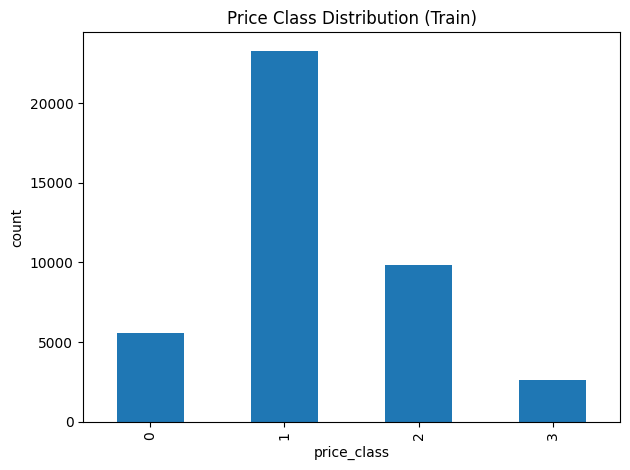

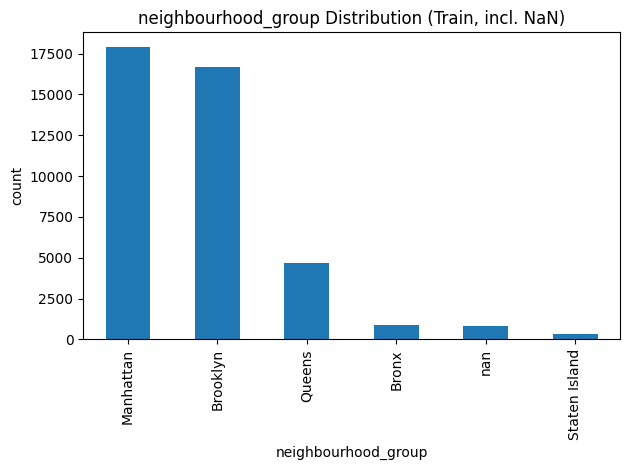

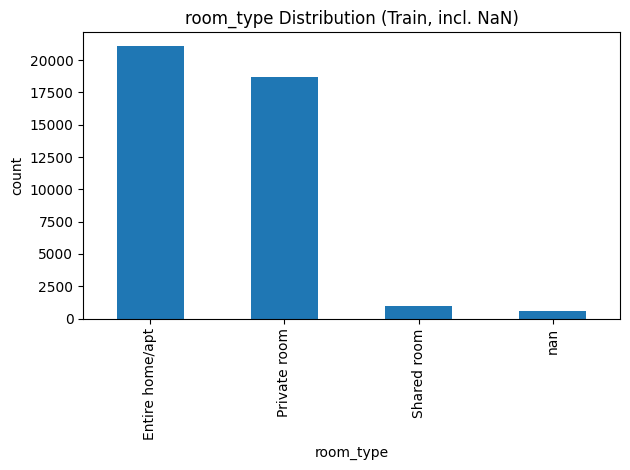

<Figure size 640x480 with 0 Axes>

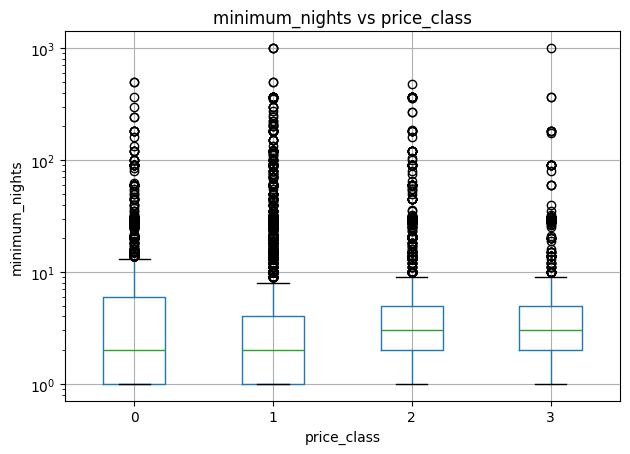

<Figure size 640x480 with 0 Axes>

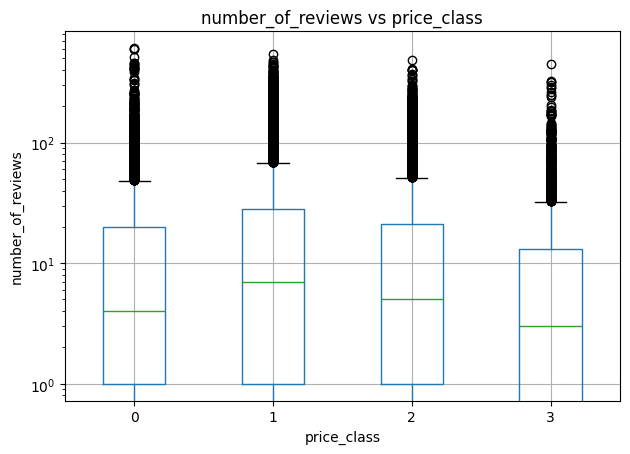

<Figure size 640x480 with 0 Axes>

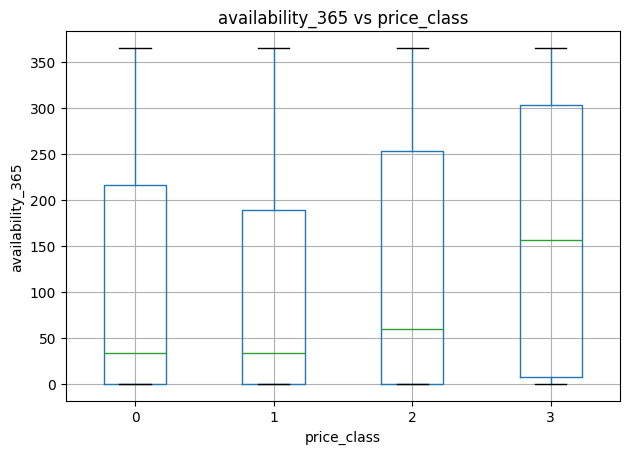

<Figure size 640x480 with 0 Axes>

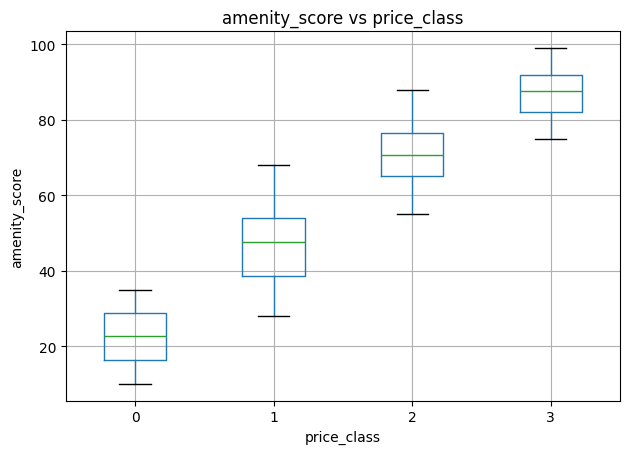

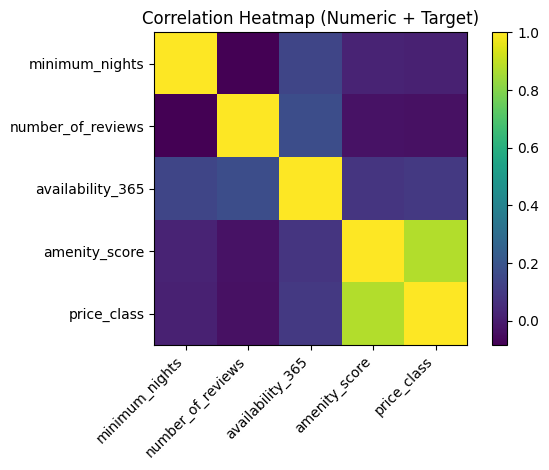


Correlation with price_class:
price_class          1.000000
amenity_score        0.875322
availability_365     0.096385
minimum_nights       0.015818
number_of_reviews   -0.034141
Name: price_class, dtype: float64


In [5]:
# 1) Target distribution
plt.figure()
train_df["price_class"].value_counts().sort_index().plot(kind="bar")
plt.title("Price Class Distribution (Train)")
plt.xlabel("price_class")
plt.ylabel("count")
plt.tight_layout()
plt.show()

# 2) Categorical distributions
for col in ["neighbourhood_group", "room_type"]:
    plt.figure()
    train_df[col].value_counts(dropna=False).plot(kind="bar")
    plt.title(f"{col} Distribution (Train, incl. NaN)")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

# 3) Numeric vs class boxplots
num_cols = ["minimum_nights", "number_of_reviews", "availability_365", "amenity_score"]

for col in num_cols:
    plt.figure()
    train_df.boxplot(column=col, by="price_class")
    plt.title(f"{col} vs price_class")
    plt.suptitle("")  # remove automatic title
    plt.xlabel("price_class")
    plt.ylabel(col)
    if col == "minimum_nights" or col == "number_of_reviews":
        plt.yscale("log")
    plt.tight_layout()
    plt.show()

# 4) Correlation (numeric + target)
corr_df = train_df[num_cols + ["price_class"]].copy()
corr = corr_df.corr(numeric_only=True)

plt.figure()
plt.imshow(corr, interpolation="nearest")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation Heatmap (Numeric + Target)")
plt.colorbar()
plt.tight_layout()
plt.show()

print("\nCorrelation with price_class:")
print(corr["price_class"].sort_values(ascending=False))

**A3) Preprocess (impute + one-hot + standardize) and return X/y for later parts**

In [6]:
from sklearn.model_selection import train_test_split

cat_cols = ["neighbourhood_group", "room_type"]
num_cols = ["minimum_nights", "number_of_reviews", "availability_365", "amenity_score"]
target_col = "price_class"

def preprocess_fit_transform(train_df, test_df):
    train = train_df.copy()
    test  = test_df.copy()

    # Fill missing categorical
    for c in cat_cols:
        train[c] = train[c].fillna("Unknown")
        test[c]  = test[c].fillna("Unknown")

    # Fill missing numeric with train median
    medians = {}
    for c in num_cols:
        medians[c] = train[c].median()
        train[c] = train[c].fillna(medians[c])
        test[c]  = test[c].fillna(medians[c])

    # One-hot encode (fit on combined to keep same columns)
    combined = pd.concat([train[cat_cols], test[cat_cols]], axis=0)
    combined_oh = pd.get_dummies(combined, columns=cat_cols)

    train_oh = combined_oh.iloc[:len(train)].reset_index(drop=True)
    test_oh  = combined_oh.iloc[len(train):].reset_index(drop=True)

    # Standardize numeric with train mean/std
    mu = train[num_cols].mean()
    sd = train[num_cols].std().replace(0, 1.0)

    train_num = (train[num_cols] - mu) / sd
    test_num  = (test[num_cols] - mu) / sd

    # Final feature matrices
    X_train = pd.concat([train_num.reset_index(drop=True), train_oh], axis=1).values.astype(np.float32)
    X_test  = pd.concat([test_num.reset_index(drop=True),  test_oh], axis=1).values.astype(np.float32)

    y_train = train[target_col].values.astype(np.int64)

    feature_names = list(pd.concat([train_num.reset_index(drop=True), train_oh], axis=1).columns)

    return X_train, y_train, X_test, feature_names

X, y, X_test, feature_names = preprocess_fit_transform(train_df, test_df)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("X_test shape:", X_test.shape)
print("Total features:", len(feature_names))

X shape: (41348, 14)
y shape: (41348,)
X_test shape: (7297, 14)
Total features: 14


Part B(a) — From-scratch NumPy MLP + Accuracy curves

**B(a)1) Simple NumPy MLP (2 hidden layers) + training loop**

In [7]:
def one_hot(y, num_classes=4):
    out = np.zeros((len(y), num_classes), dtype=np.float32)
    out[np.arange(len(y)), y] = 1.0
    return out

def softmax(z):
    z = z - np.max(z, axis=1, keepdims=True)
    expz = np.exp(z)
    return expz / np.sum(expz, axis=1, keepdims=True)

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_deriv(a):  # derivative using activation a
    return a * (1.0 - a)

def relu(x):
    return np.maximum(0.0, x)

def relu_deriv(z):
    return (z > 0).astype(np.float32)

def accuracy_from_probs(probs, y_true):
    pred = np.argmax(probs, axis=1)
    return (pred == y_true).mean()

def train_numpy_mlp(X_train, y_train, X_val, y_val,
                    h1=64, h2=32, lr=0.05, iters=300,
                    act="relu", seed=42):
    np.random.seed(seed)
    n, d = X_train.shape
    k = 4

    # init weights small
    W1 = np.random.randn(d, h1).astype(np.float32)
    b1 = np.zeros((1, h1), dtype=np.float32)

    W2 = np.random.randn(h1, h2).astype(np.float32)
    b2 = np.zeros((1, h2), dtype=np.float32)

    W3 = np.random.randn(h2, k).astype(np.float32)
    b3 = np.zeros((1, k), dtype=np.float32)

    Y_train_oh = one_hot(y_train, k)
    Y_val_oh   = one_hot(y_val, k)

    train_accs, val_accs = [], []
    gradW1_list, gradW2_list = [], []

    for t in range(iters):
        # forward
        z1 = X_train @ W1 + b1
        if act == "sigmoid":
            a1 = sigmoid(z1)
        else:
            a1 = relu(z1)

        z2 = a1 @ W2 + b2
        if act == "sigmoid":
            a2 = sigmoid(z2)
        else:
            a2 = relu(z2)

        z3 = a2 @ W3 + b3
        probs = softmax(z3)

        # loss gradient (softmax + CE)
        d3 = (probs - Y_train_oh) / n  # average over batch

        # grads for W3, b3
        gW3 = a2.T @ d3
        gb3 = np.sum(d3, axis=0, keepdims=True)

        # backprop to layer2
        da2 = d3 @ W3.T
        if act == "sigmoid":
            d2 = da2 * sigmoid_deriv(a2)
        else:
            d2 = da2 * relu_deriv(z2)

        gW2 = a1.T @ d2
        gb2 = np.sum(d2, axis=0, keepdims=True)

        # backprop to layer1
        da1 = d2 @ W2.T
        if act == "sigmoid":
            d1 = da1 * sigmoid_deriv(a1)
        else:
            d1 = da1 * relu_deriv(z1)

        gW1 = X_train.T @ d1
        gb1 = np.sum(d1, axis=0, keepdims=True)

        # save gradient magnitudes (for Part B(b))
        gradW1_list.append(np.mean(np.abs(gW1)))
        gradW2_list.append(np.mean(np.abs(gW2)))

        # update
        W1 -= lr * gW1; b1 -= lr * gb1
        W2 -= lr * gW2; b2 -= lr * gb2
        W3 -= lr * gW3; b3 -= lr * gb3

        # track accuracy (train + val)
        train_acc = accuracy_from_probs(probs, y_train)

        # val forward
        z1v = X_val @ W1 + b1
        a1v = sigmoid(z1v) if act == "sigmoid" else relu(z1v)
        z2v = a1v @ W2 + b2
        a2v = sigmoid(z2v) if act == "sigmoid" else relu(z2v)
        z3v = a2v @ W3 + b3
        probsv = softmax(z3v)
        val_acc = accuracy_from_probs(probsv, y_val)

        train_accs.append(train_acc)
        val_accs.append(val_acc)

        if (t + 1) % 50 == 0:
            print(f"{act.upper()} Iter {t+1}/{iters} | train_acc={train_acc:.4f} | val_acc={val_acc:.4f}")

    params = {"W1":W1,"b1":b1,"W2":W2,"b2":b2,"W3":W3,"b3":b3}
    history = {"train_acc":train_accs, "val_acc":val_accs,
               "gW1":gradW1_list, "gW2":gradW2_list}
    return params, history

**B(a)2) Train/Val split + run Sigmoid and ReLU + plot accuracy curves**

> Add blockquote



/tmp/ipython-input-3155583395.py:12: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


SIGMOID Iter 50/300 | train_acc=0.6065 | val_acc=0.6087
SIGMOID Iter 100/300 | train_acc=0.6898 | val_acc=0.6881
SIGMOID Iter 150/300 | train_acc=0.7252 | val_acc=0.7179
SIGMOID Iter 200/300 | train_acc=0.7420 | val_acc=0.7323
SIGMOID Iter 250/300 | train_acc=0.7531 | val_acc=0.7424
SIGMOID Iter 300/300 | train_acc=0.7624 | val_acc=0.7521
RELU Iter 50/300 | train_acc=0.7396 | val_acc=0.7336
RELU Iter 100/300 | train_acc=0.7712 | val_acc=0.7661
RELU Iter 150/300 | train_acc=0.7844 | val_acc=0.7768
RELU Iter 200/300 | train_acc=0.7956 | val_acc=0.7874
RELU Iter 250/300 | train_acc=0.8010 | val_acc=0.7929
RELU Iter 300/300 | train_acc=0.8053 | val_acc=0.7950


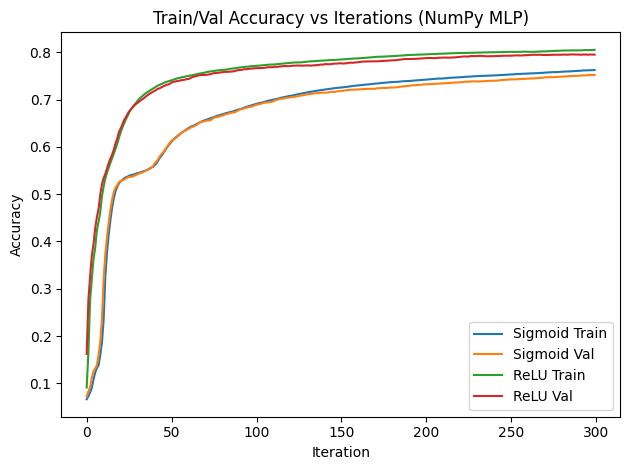

Final Sigmoid train/val: 0.7624402926416349 0.7521160822249093
Final ReLU   train/val: 0.8052784327952113 0.7950423216444982


In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train Sigmoid model
sig_params, sig_hist = train_numpy_mlp(
    X_train, y_train, X_val, y_val,
    h1=64, h2=32, lr=0.05, iters=300, act="sigmoid"
)

# Train ReLU model
relu_params, relu_hist = train_numpy_mlp(
    X_train, y_train, X_val, y_val,
    h1=64, h2=32, lr=0.02, iters=300, act="relu"
)

# Plot accuracy curves (as asked)
plt.figure()
plt.plot(sig_hist["train_acc"], label="Sigmoid Train")
plt.plot(sig_hist["val_acc"], label="Sigmoid Val")
plt.plot(relu_hist["train_acc"], label="ReLU Train")
plt.plot(relu_hist["val_acc"], label="ReLU Val")
plt.title("Train/Val Accuracy vs Iterations (NumPy MLP)")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

print("Final Sigmoid train/val:", sig_hist["train_acc"][-1], sig_hist["val_acc"][-1])
print("Final ReLU   train/val:", relu_hist["train_acc"][-1], relu_hist["val_acc"][-1])

**Part B(b) — Gradient magnitude plots**

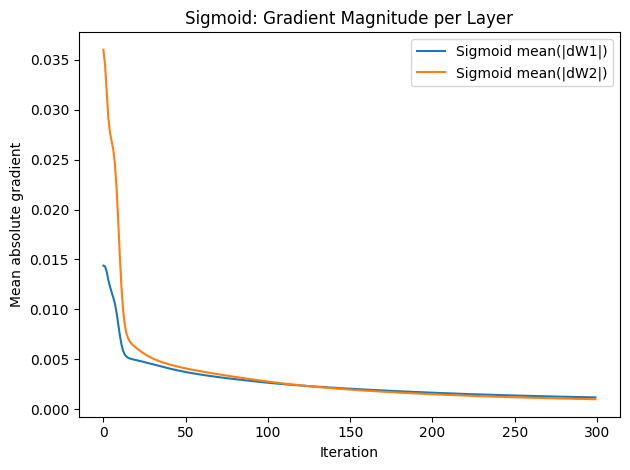

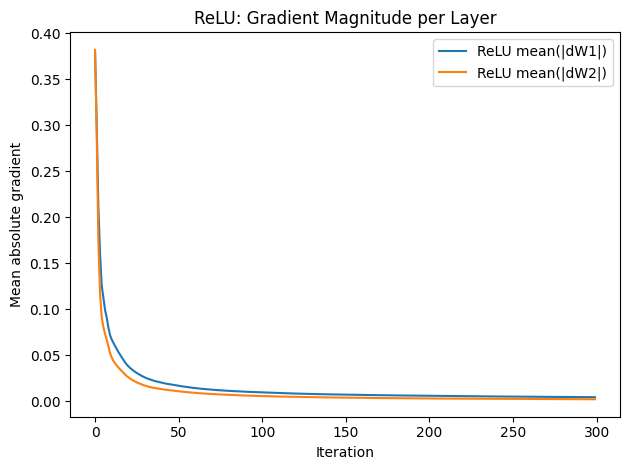

In [9]:
plt.figure()
plt.plot(sig_hist["gW1"], label="Sigmoid mean(|dW1|)")
plt.plot(sig_hist["gW2"], label="Sigmoid mean(|dW2|)")
plt.title("Sigmoid: Gradient Magnitude per Layer")
plt.xlabel("Iteration")
plt.ylabel("Mean absolute gradient")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(relu_hist["gW1"], label="ReLU mean(|dW1|)")
plt.plot(relu_hist["gW2"], label="ReLU mean(|dW2|)")
plt.title("ReLU: Gradient Magnitude per Layer")
plt.xlabel("Iteration")
plt.ylabel("Mean absolute gradient")
plt.legend()
plt.tight_layout()
plt.show()

**Part C(a) — Derivation result + “handwritten pseudocode” style code**


This code computes dL/dx for one sample using the trained NumPy network.

In [10]:
def dLdx_single_sample(x, y_class, params, act="relu"):
    # x: shape (d,)
    # y_class: integer 0..3

    W1, b1 = params["W1"], params["b1"]
    W2, b2 = params["W2"], params["b2"]
    W3, b3 = params["W3"], params["b3"]

    x = x.reshape(1, -1).astype(np.float32)
    y = np.zeros((1, 4), dtype=np.float32)
    y[0, y_class] = 1.0

    # forward
    z1 = x @ W1 + b1
    if act == "sigmoid":
        a1 = sigmoid(z1)
    else:
        a1 = relu(z1)

    z2 = a1 @ W2 + b2
    if act == "sigmoid":
        a2 = sigmoid(z2)
    else:
        a2 = relu(z2)

    z3 = a2 @ W3 + b3
    p = softmax(z3)

    # backward
    d3 = (p - y)  # (1,4)

    da2 = d3 @ W3.T
    if act == "sigmoid":
        d2 = da2 * sigmoid_deriv(a2)
    else:
        d2 = da2 * relu_deriv(z2)

    da1 = d2 @ W2.T
    if act == "sigmoid":
        d1 = da1 * sigmoid_deriv(a1)
    else:
        d1 = da1 * relu_deriv(z1)

    # input gradient
    gx = d1 @ W1.T   # (1,d)
    return gx.flatten(), p.flatten()

# example: compute gradient for first val sample with ReLU model
gx, probs = dLdx_single_sample(X_val[0], y_val[0], relu_params, act="relu")
print("Pred probs:", probs)
print("Top 10 input gradients (abs):")
top_idx = np.argsort(-np.abs(gx))[:10]
for i in top_idx:
    print(feature_names[i], float(abs(gx[i])))

Pred probs: [2.2714686e-11 9.9900252e-01 9.9746836e-04 2.7367461e-13]
Top 10 input gradients (abs):
neighbourhood_group_Manhattan 27.090435028076172
neighbourhood_group_Queens 19.77572250366211
room_type_Unknown 15.140121459960938
amenity_score 13.624846458435059
room_type_Private room 11.201589584350586
number_of_reviews 10.458161354064941
minimum_nights 9.976713180541992
neighbourhood_group_Brooklyn 6.296548843383789
neighbourhood_group_Bronx 6.204501152038574
neighbourhood_group_Unknown 4.495522499084473


**Part C(b) — PyTorch method + ranked features (mean |dL/dx|)**
C(b)1) PyTorch MLP + training

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLP2(nn.Module):
    def __init__(self, d, h1=64, h2=32, k=4):
        super().__init__()
        self.fc1 = nn.Linear(d, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, k)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.fc3(x)  # logits
        return x

def train_torch_mlp(X_train, y_train, X_val, y_val, epochs=10, lr=1e-3, batch_size=256):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    Xtr = torch.tensor(X_train, dtype=torch.float32)
    ytr = torch.tensor(y_train, dtype=torch.long)
    Xva = torch.tensor(X_val, dtype=torch.float32)
    yva = torch.tensor(y_val, dtype=torch.long)

    model = MLP2(d=X_train.shape[1]).to(device)
    loss_fn = nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters(), lr=lr)

    def acc(model, X, y):
        model.eval()
        with torch.no_grad():
            logits = model(X.to(device))
            pred = torch.argmax(logits, dim=1)
            return (pred.cpu() == y.cpu()).float().mean().item()

    n = len(Xtr)
    for ep in range(1, epochs+1):
        model.train()
        idx = torch.randperm(n)
        for i in range(0, n, batch_size):
            batch_idx = idx[i:i+batch_size]
            xb = Xtr[batch_idx].to(device)
            yb = ytr[batch_idx].to(device)

            opt.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            opt.step()

        tr_acc = acc(model, Xtr, ytr)
        va_acc = acc(model, Xva, yva)
        print(f"Epoch {ep}/{epochs} | train_acc={tr_acc:.4f} | val_acc={va_acc:.4f}")

    return model

torch_model = train_torch_mlp(X_train, y_train, X_val, y_val, epochs=10, lr=1e-3)

Epoch 1/10 | train_acc=0.8046 | val_acc=0.7975
Epoch 2/10 | train_acc=0.8299 | val_acc=0.8224
Epoch 3/10 | train_acc=0.8344 | val_acc=0.8272
Epoch 4/10 | train_acc=0.8366 | val_acc=0.8264
Epoch 5/10 | train_acc=0.8367 | val_acc=0.8277
Epoch 6/10 | train_acc=0.8337 | val_acc=0.8219
Epoch 7/10 | train_acc=0.8293 | val_acc=0.8210
Epoch 8/10 | train_acc=0.8277 | val_acc=0.8177
Epoch 9/10 | train_acc=0.8339 | val_acc=0.8237
Epoch 10/10 | train_acc=0.8328 | val_acc=0.8227


**C(b)2) Feature ranking with mean absolute input gradient**

In [12]:
def rank_features_by_input_grad(model, X_data, y_data, feature_names, batch_size=256):
    device = next(model.parameters()).device
    model.eval()

    X = torch.tensor(X_data, dtype=torch.float32)
    y = torch.tensor(y_data, dtype=torch.long)

    scores = torch.zeros(X.shape[1], dtype=torch.float32)

    loss_fn = nn.CrossEntropyLoss()

    n = len(X)
    for i in range(0, n, batch_size):
        xb = X[i:i+batch_size].clone().to(device)
        yb = y[i:i+batch_size].to(device)

        xb.requires_grad_(True)

        logits = model(xb)
        loss = loss_fn(logits, yb)

        model.zero_grad()
        if xb.grad is not None:
            xb.grad.zero_()
        loss.backward()

        grads = xb.grad.detach().abs().mean(dim=0).cpu()
        scores += grads

    scores = scores / (n / batch_size)
    scores_np = scores.numpy()

    order = np.argsort(-scores_np)
    ranked = [(feature_names[j], float(scores_np[j])) for j in order]
    return ranked

ranked_features = rank_features_by_input_grad(torch_model, X_val, y_val, feature_names)

print("\nTop 14 features by mean(|dL/dx|):")
for name, score in ranked_features[:20]:
    print(f"{name:35s}  {score:.6f}")


Top 14 features by mean(|dL/dx|):
amenity_score                        0.005185
room_type_Entire home/apt            0.001574
room_type_Private room               0.001553
neighbourhood_group_Queens           0.001363
neighbourhood_group_Bronx            0.001249
neighbourhood_group_Brooklyn         0.001233
neighbourhood_group_Staten Island    0.001200
neighbourhood_group_Manhattan        0.001184
room_type_Unknown                    0.001174
neighbourhood_group_Unknown          0.001067
room_type_Shared room                0.000988
minimum_nights                       0.000508
availability_365                     0.000325
number_of_reviews                    0.000321


**Part D — Test evaluation + generalization gap discussion**
D1) Evaluate test accuracy (you need labels for test; usually you don’t have them)

So do this:
	•	report train/val accuracy from earlier
	•	generate test predictions file to submit

D2) Make predictions on test (using the NumPy ReLU model)

In [13]:
def predict_numpy_mlp(X_in, params, act="relu"):
    W1, b1 = params["W1"], params["b1"]
    W2, b2 = params["W2"], params["b2"]
    W3, b3 = params["W3"], params["b3"]

    z1 = X_in @ W1 + b1
    a1 = sigmoid(z1) if act == "sigmoid" else relu(z1)

    z2 = a1 @ W2 + b2
    a2 = sigmoid(z2) if act == "sigmoid" else relu(z2)

    z3 = a2 @ W3 + b3
    probs = softmax(z3)
    pred = np.argmax(probs, axis=1)
    return pred, probs

test_pred, test_probs = predict_numpy_mlp(X_test, relu_params, act="relu")
print("Test predictions shape:", test_pred.shape)
print("First 10 preds:", test_pred[:10])

Test predictions shape: (7297,)
First 10 preds: [2 2 3 2 1 3 1 2 1 0]


In [14]:
#D3) Save prediction CSV -- test accuracy
# D3) Test accuracy (no CSV export)

y_test = test_df["price_class"].values.astype(np.int64)

# 2) Get predictions from your trained model
test_pred, test_probs = predict_numpy_mlp(X_test, relu_params, act="relu")  # or sig_params, act="sigmoid"

# 3) Compute test accuracy
test_acc = (test_pred == y_test).mean()
print("Test Accuracy:", round(float(test_acc), 4))


for c in [0, 1, 2, 3]:
    mask = (y_test == c)
    acc_c = (test_pred[mask] == y_test[mask]).mean()
    print(f"Class {c} accuracy:", round(float(acc_c), 4), " | count:", int(mask.sum()))


Test Accuracy: 0.363
Class 0 accuracy: 0.2513  | count: 983
Class 1 accuracy: 0.4546  | count: 4109
Class 2 accuracy: 0.2614  | count: 1737
Class 3 accuracy: 0.1709  | count: 468


Question # 2:

Section 2: Easy NumPy code (forward + backward with shared bias)

In [15]:
import numpy as np

# ---- activations ----
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def sigmoid_deriv(a):
    # derivative using activation output a = sigmoid(z)
    return a * (1.0 - a)

# output activation g1 (you can keep it sigmoid for simplicity)
def g1(z2):
    return sigmoid(z2)

def g1_deriv(yhat):
    # derivative using output yhat = sigmoid(z2)
    return yhat * (1.0 - yhat)

# simple squared error loss: L = 0.5 * ||yhat - y||^2
def loss_sq(yhat, y):
    diff = (yhat - y)
    return 0.5 * np.sum(diff * diff)

def dloss_dyhat_sq(yhat, y):
    # derivative of 0.5*(yhat-y)^2 is (yhat - y)
    return (yhat - y)


# ---- forward + backward (shared bias) ----
def forward_backward_shared_bias(x, y, W, U, b):
    """
    x: (d,)
    y: (m,)  (same size as output)
    W: (h, d)
    U: (m, h)
    b: (h,) OR (m,) ?

    IMPORTANT:
    To share bias across two layers, b must match BOTH z1 and z2 shapes.
    So we will assume:
      - hidden size h == output size m
    That makes b shape (h,) and works for both layers.
    """

    # forward
    z1 = W @ x + b               # (h,)
    h1 = sigmoid(z1)             # (h,)

    z2 = U @ h1 + b              # (h,) because output size = h
    yhat = g1(z2)                # (h,)

    L = loss_sq(yhat, y)

    # backward
    dL_dyhat = dloss_dyhat_sq(yhat, y)     # (h,)
    delta2 = dL_dyhat * g1_deriv(yhat)     # (h,) = dL/dz2

    # grads for U and (bias path via z2)
    dL_dU = np.outer(delta2, h1)           # (h,h)
    db_via_z2 = delta2                      # (h,)

    # backprop into h1 then z1
    dL_dh1 = U.T @ delta2                  # (h,)
    delta1 = dL_dh1 * sigmoid_deriv(h1)    # (h,) = dL/dz1

    # grads for W and (bias path via z1)
    dL_dW = np.outer(delta1, x)            # (h,d)
    db_via_z1 = delta1                      # (h,)

    # final shared bias gradient (sum of both contributions)
    dL_db = db_via_z1 + db_via_z2          # (h,)

    cache = {
        "z1": z1, "h1": h1, "z2": z2, "yhat": yhat,
        "delta1": delta1, "delta2": delta2
    }

    return L, yhat, dL_dW, dL_dU, dL_db, cache

Section 3: Run a small example

In [16]:
np.random.seed(0)

d = 5   # input size
h = 4   # hidden size
# IMPORTANT: output size must equal h for shared bias to match shapes
# so output size = h

x = np.random.randn(d).astype(np.float64)
y = np.random.randn(h).astype(np.float64)

W = 0.1 * np.random.randn(h, d).astype(np.float64)
U = 0.1 * np.random.randn(h, h).astype(np.float64)
b = np.zeros(h, dtype=np.float64)

L, yhat, dW, dU, db, cache = forward_backward_shared_bias(x, y, W, U, b)

print("Loss:", L)
print("yhat:", yhat)
print("Mean |dW|:", np.mean(np.abs(dW)))
print("Mean |dU|:", np.mean(np.abs(dU)))
print("db:", db)
print("Check: db = delta1 + delta2 ->", np.allclose(db, cache["delta1"] + cache["delta2"]))

Loss: 1.5908080438803318
yhat: [0.51441492 0.4869206  0.49225436 0.46923937]
Mean |dW|: 0.017642658040635258
Mean |dU|: 0.11255265376111821
db: [ 0.39100634 -0.12082177  0.16963287  0.12618362]
Check: db = delta1 + delta2 -> True


Section 4: Numerical gradient check for db

In [17]:
def numerical_grad_b(x, y, W, U, b, eps=1e-6):
    num_db = np.zeros_like(b)
    for i in range(len(b)):
        b_plus = b.copy()
        b_minus = b.copy()
        b_plus[i] += eps
        b_minus[i] -= eps

        Lp, _, _, _, _, _ = forward_backward_shared_bias(x, y, W, U, b_plus)
        Lm, _, _, _, _, _ = forward_backward_shared_bias(x, y, W, U, b_minus)

        num_db[i] = (Lp - Lm) / (2 * eps)
    return num_db

num_db = numerical_grad_b(x, y, W, U, b)

print("Analytic db:", db)
print("Numeric   db:", num_db)
print("Max abs diff:", np.max(np.abs(db - num_db)))

Analytic db: [ 0.39100634 -0.12082177  0.16963287  0.12618362]
Numeric   db: [ 0.39100634 -0.12082177  0.16963287  0.12618362]
Max abs diff: 1.5667830921550774e-10
